In [1]:
import mucus_rust as mc
import matplotlib.pyplot as plt
import numpy as np
import os
import mpltex
import tidynamics as tid
from pathlib import Path
from scipy import integrate
from time import time
import h5py

figpath = "/home/janmak98/reports/midterm/figures/msd/"

In [2]:
# LIST ALL CONFIGS
cfg_dir = "/net/data04/janmak98/results/january/growing_mesh/notracer/configs"
cfg_dir = "/net/data04/janmak98/results/january/growing_mesh/notracer/configs"
cfg_dir = "/net/data04/janmak98/results/january/relaxed_mesh/notracer/configs"
cfg_relpaths = os.listdir(cfg_dir)
cfg_paths = [cfg_dir + "/" + cfg_fname for cfg_fname in cfg_relpaths]
for i, cfg_path in enumerate(cfg_paths):
    print(i, cfg_path)

0 /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_8wtp.toml
1 /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_4wtp.toml
2 /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_2wtp.toml


In [3]:
idx_selected = [4, 0, 2, 3]
label_selected = ["1 wt\%", "2 wt\%", "4 wt\%", "8 wt\%"]
idx_selected = [2]
label_selected = ["2 wt\%"]

print("sanity check:")
for i, idx in enumerate(idx_selected):
    print(label_selected[i], cfg_paths[idx], mc.utils.get_number_of_frames(mc.Config.from_toml(cfg_paths[idx])), "frames")

sanity check:
2 wt\% /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_2wtp.toml 200000 frames


stress_tensor with the same parameters already exists in the dataset.


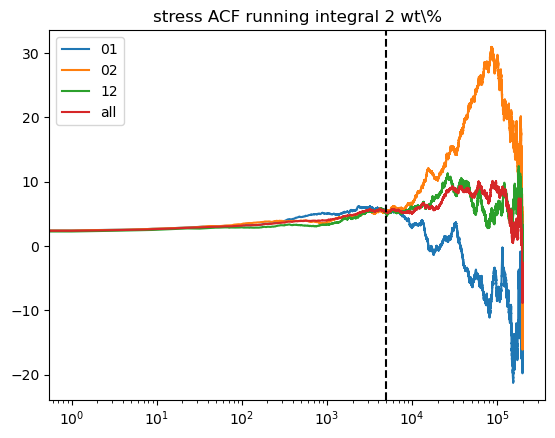

In [5]:
kB = 1.380649e-23 # m^2 kg s^-2 K^-1
T = 300 # K

idx_max_all = np.array([5e4, 5e4, 5e4, 5e4], dtype=int)
idx_max_all = np.array([5e3], dtype=int)

strides = [1, 1, 1, 1]
strides = [1]

sigma_all = []
acf_all = []
acf_single_all = []
running_integral_all = []
running_integral_single_all = []

eqilibration_offset_index = 1000

for idx_label, idx in enumerate(idx_selected):
    
    # load stress tensor
    cfg = mc.Config.from_toml(cfg_paths[idx])
    sys = mc.Analysis(cfg, stride=strides[idx_label])
    sigma_t = sys.virial_stress_tensor(return_all=True)
    dt = mc.utils.get_timestep_seconds(cfg)
    
    # calculate ACF for every off diagonal element and average over the 3 ACFs
    acf = np.zeros_like(sigma_t[eqilibration_offset_index:,0,1])
    acf_single = np.zeros((3,len(acf)))
    idx = 0
    for a in range(3):
        for b in range(a+1, 3):
            #acf_current = tid.acf(sigma_t[:,a,b])
            acf_current = tid.acf(sigma_t[eqilibration_offset_index:,a,b]-np.mean(sigma_t[eqilibration_offset_index:,a,b]))
            acf += acf_current
            acf_single[idx] = np.copy(acf_current)
            idx += 1
            #plt.figure()
            #plt.plot(sigma_t[eqilibration_offset_index:,a,b]-np.mean(sigma_t[eqilibration_offset_index:,a,b]))
    
    # convert to SI units
    red2m = cfg.r0_nm*1e-9
    volume = cfg.lbox**3  
    acf = volume*red2m**3*acf/3/kB/T                # Pa   # SI units
    acf_single = volume*red2m**3*acf_single/kB/T    # Pa   # SI units

    # subtract averages from acf
    acf -= np.mean(acf)
    acf_single -= np.mean(acf_single, axis=1)[:,None]

    acf_all.append(acf)
    acf_single_all.append(acf_single)
    
    running_integral = integrate.cumulative_trapezoid(acf, dx=dt, initial=0)
    #print(running_integral.shape)

    running_integral_single = np.zeros_like(acf_single)
    for i in range(3):
        running_integral_single[i] = integrate.cumulative_trapezoid(acf_single[i], dx=dt, initial=0)
    running_integral_all.append(running_integral)
    running_integral_single_all.append(running_integral_single)
    
    # plot 
    single_label = ["01", "02", "12"]
    plt.figure()

    for i in range(3):
        plt.plot(running_integral_single[i], label=single_label[i])
    plt.plot(running_integral, label="all")
    plt.axvline(x=idx_max_all[idx_label], color="k", linestyle="--")
    plt.xscale("log")
    #plt.ylim((0, 100))
    plt.title(f"stress ACF running integral {label_selected[idx_label]}")
    plt.legend()
    #plt.ylim((0, 1))
    plt.show()
    

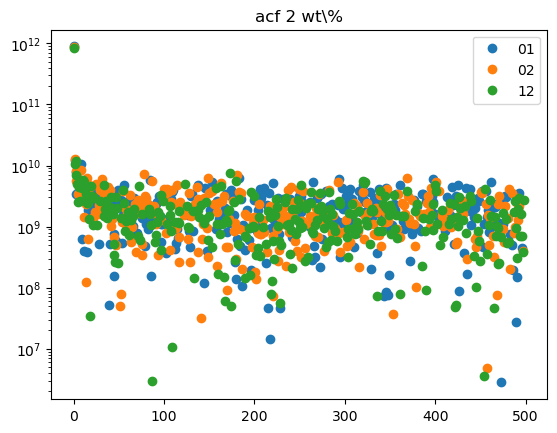

In [6]:
# plot acfs
for idx_label, idx in enumerate(idx_selected):
    plt.figure()
    for i in range(3):
        plt.plot(acf_single_all[idx_label][i][:500], "o", label=single_label[i])
        #plt.scatter(acf_single_all[idx_label][i][:50], label=single_label[i])
    #plt.plot(acf_all[idx_label][:(idx_max_all[idx_label]+100)], label="all")
    #plt.axvline(x=idx_max_all[idx_label], color="k", linestyle="--")
    plt.yscale("log")
    #plt.yscale("log")
    plt.title(f"acf {label_selected[idx_label]}")
    plt.legend()
    #plt.ylim((-1e2, 1e10))
    plt.show()

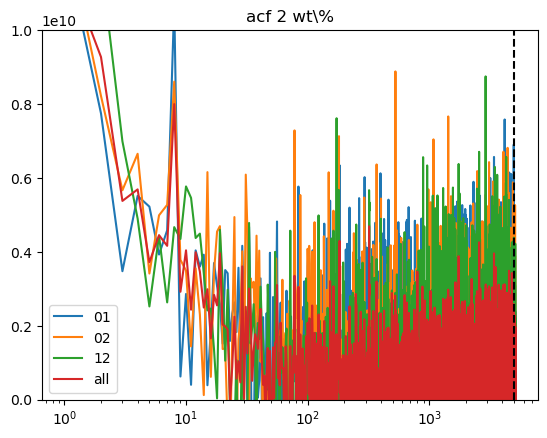

In [7]:
# plot acfs
for idx_label, idx in enumerate(idx_selected):
    plt.figure()
    for i in range(3):
        plt.plot(acf_single_all[idx_label][i][:(idx_max_all[idx_label]+100)], label=single_label[i])
    plt.plot(acf_all[idx_label][:(idx_max_all[idx_label]+100)], label="all")
    plt.axvline(x=idx_max_all[idx_label], color="k", linestyle="--")
    plt.xscale("log")
    #plt.yscale("log")
    plt.title(f"acf {label_selected[idx_label]}")
    plt.legend()
    plt.ylim((-1e2, 1e10))
    plt.show()

In [8]:
# calculate viscosities
complex_viscosity_all = []
complex_viscosity_single_all = []
freq_all = []
freq_steps_all = []

for idx_label, idx in enumerate(idx_selected):
    
    idx_plateau = idx_max_all[idx_label]
    acf = acf_all[idx_label]
    acf[0] = acf[0]/2                                                       #! correct for trapezoidal integration 
    acf_single = acf_single_all[idx_label]

    complex_viscosity = np.fft.fft(np.append(acf[:idx_plateau], np.zeros(len(acf[idx_plateau:]))))

    N_fft = len(complex_viscosity)
    freq = np.fft.fftfreq(N_fft, d=dt)
    freq_steps = np.fft.fftfreq(N_fft, d=1)

    complex_viscosity_single = np.zeros((3, len(complex_viscosity)), dtype=np.complex128)
    for i in range(3):
        complex_viscosity_single[i] = np.fft.fft(np.append(acf_single[i][:idx_plateau], np.zeros(len(acf_single[i][idx_plateau:]))))
        
    complex_viscosity_all.append(complex_viscosity)
    complex_viscosity_single_all.append(complex_viscosity_single)
    freq_all.append(freq)
    freq_steps_all.append(freq_steps)

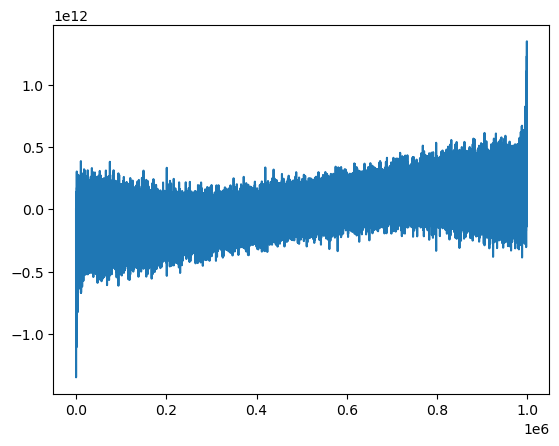

In [18]:
plt.figure()
#plt.plot(complex_viscosity.imag[1000:idx_plateau-1000])
plt.plot(complex_viscosity.imag)

In [9]:
exp_dir = "/local_scratch2/janmak98/masterthesis/experimental_results/rheology_PEO/Rheologie_PEO_Robert_compact/Rheologie_PEO_Robert_compact/etas_macro"
exp_relpaths = os.listdir(exp_dir)
exp_paths = [exp_dir + "/" + exp_fname for exp_fname in exp_relpaths]

    
wtp_exp = [1, 2, 4]

omega_exp_all = []
G_real_exp_all = []
G_imag_exp_all = []

for wtpi in wtp_exp:
    for p in exp_paths:
        if f"1000 kDa, {wtpi}.0 wt$\%$_PS200" in p:
            exp_path = p
            data = np.loadtxt(exp_path, delimiter=",")
            omega_exp_all.append(data[:,0])
            G_real_exp_all.append(data[:,1])
            G_imag_exp_all.append(data[:,2])            

In [10]:
print(G_real_exp_all[0])
print(complex_viscosity_all[0].real)
print(freq_all[0])

[0.111725   0.08984361 0.07782022 0.07017089 0.06675158 0.06622749
 0.06220018 0.06223667 0.062069   0.06081805 0.05967416 0.05971519
 0.05904905 0.05867062 0.05794929 0.05749267 0.0566565  0.05605038
 0.05494831 0.05399367 0.05180538 0.05074763 0.05009964 0.050928
 0.0540965 ]
[9.86533241e+11 9.86508909e+11 9.86426018e+11 ... 9.86255165e+11
 9.86426018e+11 9.86508909e+11]
[       0.           936238.23015704  1872476.46031408 ...
 -2808714.69047112 -1872476.46031408  -936238.23015704]


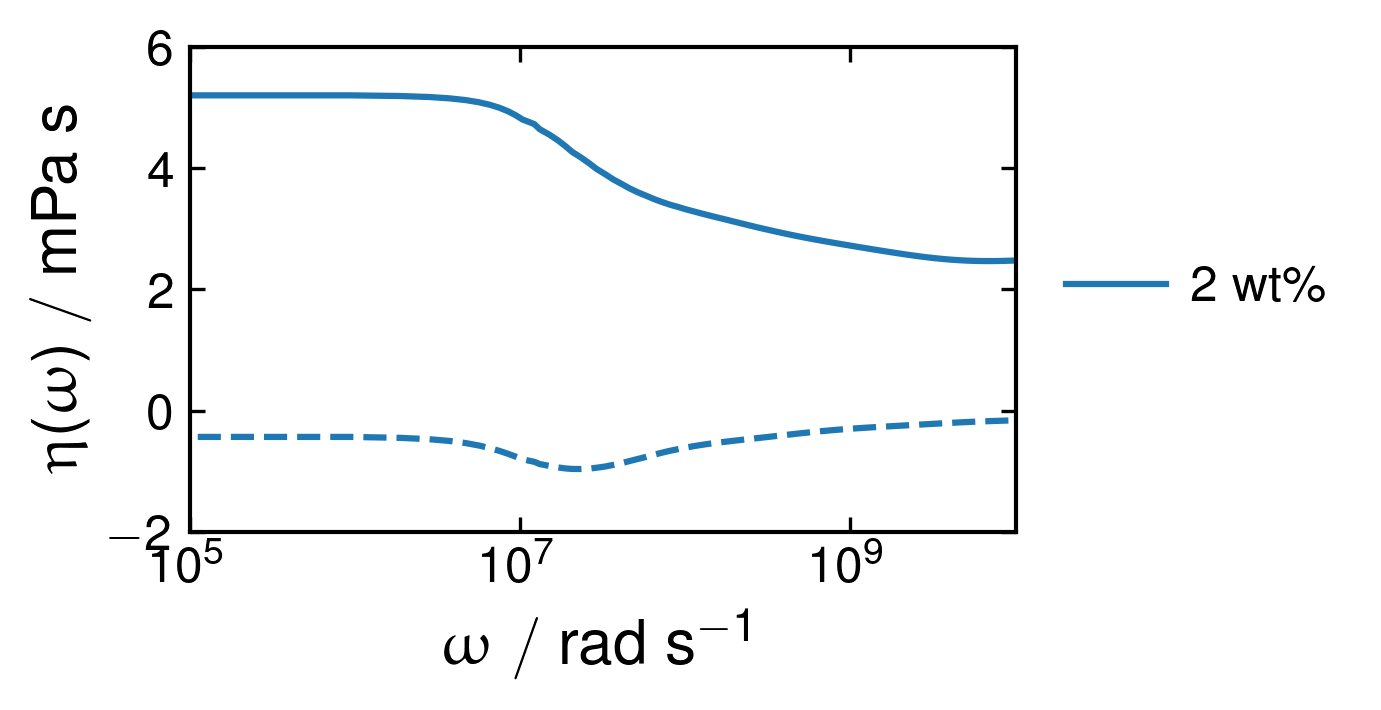

In [11]:
from scipy.ndimage import gaussian_filter1d

fontsize = 15


freq_log_filtered_all = []
freq_steps_log_filtered_all = []    
complex_viscosity_log_filtered_real_all = []
complex_viscosity_log_filtered_imag_all = []

@mpltex.aps_decorator
def myplot():
    
    fig, ax = plt.subplots(1)
    fig.dpi = 300
    fig.set_size_inches(w=3.25, h=3.25/1.618)
    
    # The default line style is iterating over
    # color, line, and marker with hollow types.
    linestyles = mpltex.linestyles()

    ax.set_xscale("log")
    #ax.set_yscale("log")
    # for i in range(3):
    #     color = next(linestyles)["color"]
    #     ax.plot(complex_viscosity_single[i].real[:idx_plateau]*dt, label=f"real {single_label[i]}", color=color)
    #     ax.plot(complex_viscosity_single[i].imag[:idx_plateau]*dt, label=f"imag {single_label[i]}", color=color, linestyle="dashed")
    
    for idx_label, idx in enumerate(idx_selected):
        
        freq = freq_all[idx_label]
        complex_viscosity = complex_viscosity_all[idx_label]
        
        idx_plateau = idx_max_all[idx_label]
        
        #log_indices = np.append(0, np.unique(np.logspace(0, np.log(idx_plateau), 100, dtype=int)))
        log_indices = np.append(0, np.unique(np.logspace(0, 4.8, 100, dtype=int)))
        
        complex_viscosity_log = complex_viscosity_all[idx_label][log_indices]
        
        freq_log_filtered_all.append(freq[log_indices])
        freq_steps_log_filtered_all.append(freq_steps_all[idx_label][log_indices])
        complex_viscosity_log_filtered_real_all.append(gaussian_filter1d((complex_viscosity_log.real)*dt, sigma=8))
        complex_viscosity_log_filtered_imag_all.append(gaussian_filter1d((complex_viscosity_log.imag)*dt, sigma=8))
        
        color = next(linestyles)["color"]

        #ax.plot(freq[:idx_plateau], complex_viscosity.real[:idx_plateau]*dt, linewidth=1.5, color=color, alpha=0.5)
        #ax.plot(freq[:idx_plateau], complex_viscosity.imag[:idx_plateau]*dt, linestyle="dashed", linewidth=1.5, color=color, alpha=0.5)
        
        ax.plot(freq[log_indices], gaussian_filter1d((complex_viscosity_log.real)*dt, sigma=8), label=f"{label_selected[idx_label]}", linewidth=1.5, color=color)
        ax.plot(freq[log_indices], gaussian_filter1d((complex_viscosity_log.imag)*dt, sigma=8), linestyle="dashed", linewidth=1.5, color=color)
        
        # ax.plot(freq[log_indices], gaussian_filter1d((complex_viscosity_log.real-complex_viscosity_log.real[-1])*dt, sigma=8), label=f"{label_selected[idx_label]}", linewidth=1.5, color=color)
        # ax.plot(freq[log_indices], gaussian_filter1d((complex_viscosity_log.imag-complex_viscosity_log.imag[-1])*dt, sigma=8), linestyle="dashed", linewidth=1.5, color=color)
        #ax.plot(freq[:idx_plateau], complex_viscosity.imag[:idx_plateau]*dt, linewidth=1.5, color=color, linestyle="dashed")
        
        #ax.plot(omega_exp_all[idx_label], 1e3*G_real_exp_all[idx_label], label=f"real (exp) {label_selected[idx_label]}", linewidth=1.5, color=color, linestyle="dotted")
    
    ax.set_xlabel(r"$\omega~/~\mathrm{rad}~\mathrm{s}^{-1}$")
    ax.set_ylabel(r"$\eta(\omega)~/~\mathrm{mPa~s}$")
    
    ax.set_xlim((1e5, 1e10))
    #ax.set_ylim((1e-1, 5e-1))

    fig.tight_layout(pad=0.1)  # make layout as tight as possible
    #fig.savefig(figpath + "vspec_N51-L14-steps10M.png")
    ax.tick_params(axis='both', which="both", labelsize=fontsize*0.8)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(fontsize)
    for line in ax.lines:
        line.set_linewidth(1.5)
        
    # ax.locator_params(nbins=5)  # limit the number of major ticks
    ax.legend(fontsize=fontsize*0.8, loc='center left', bbox_to_anchor=(1, 0.5))  # show legend in a best location
    
    plt.show()

myplot()

In [12]:
abs_viscosity_log_all = []

abs_viscosity_exp_all = []

for idx_label, idx in enumerate(idx_selected):
    
    # simulation data
    abs_visc = np.sqrt((complex_viscosity_log_filtered_real_all[idx_label].real)**2 + complex_viscosity_log_filtered_imag_all[idx_label].imag**2)
    abs_viscosity_log_all.append(abs_visc)
    
for idx_exp, wtpi in enumerate(wtp_exp):
    # experimental data
    abs_visc_exp = np.sqrt((G_real_exp_all[idx_exp]/omega_exp_all[idx_exp])**2 + (G_imag_exp_all[idx_exp]/omega_exp_all[idx_exp])**2)
    abs_viscosity_exp_all.append(abs_visc_exp)
    

0.3170603015075377


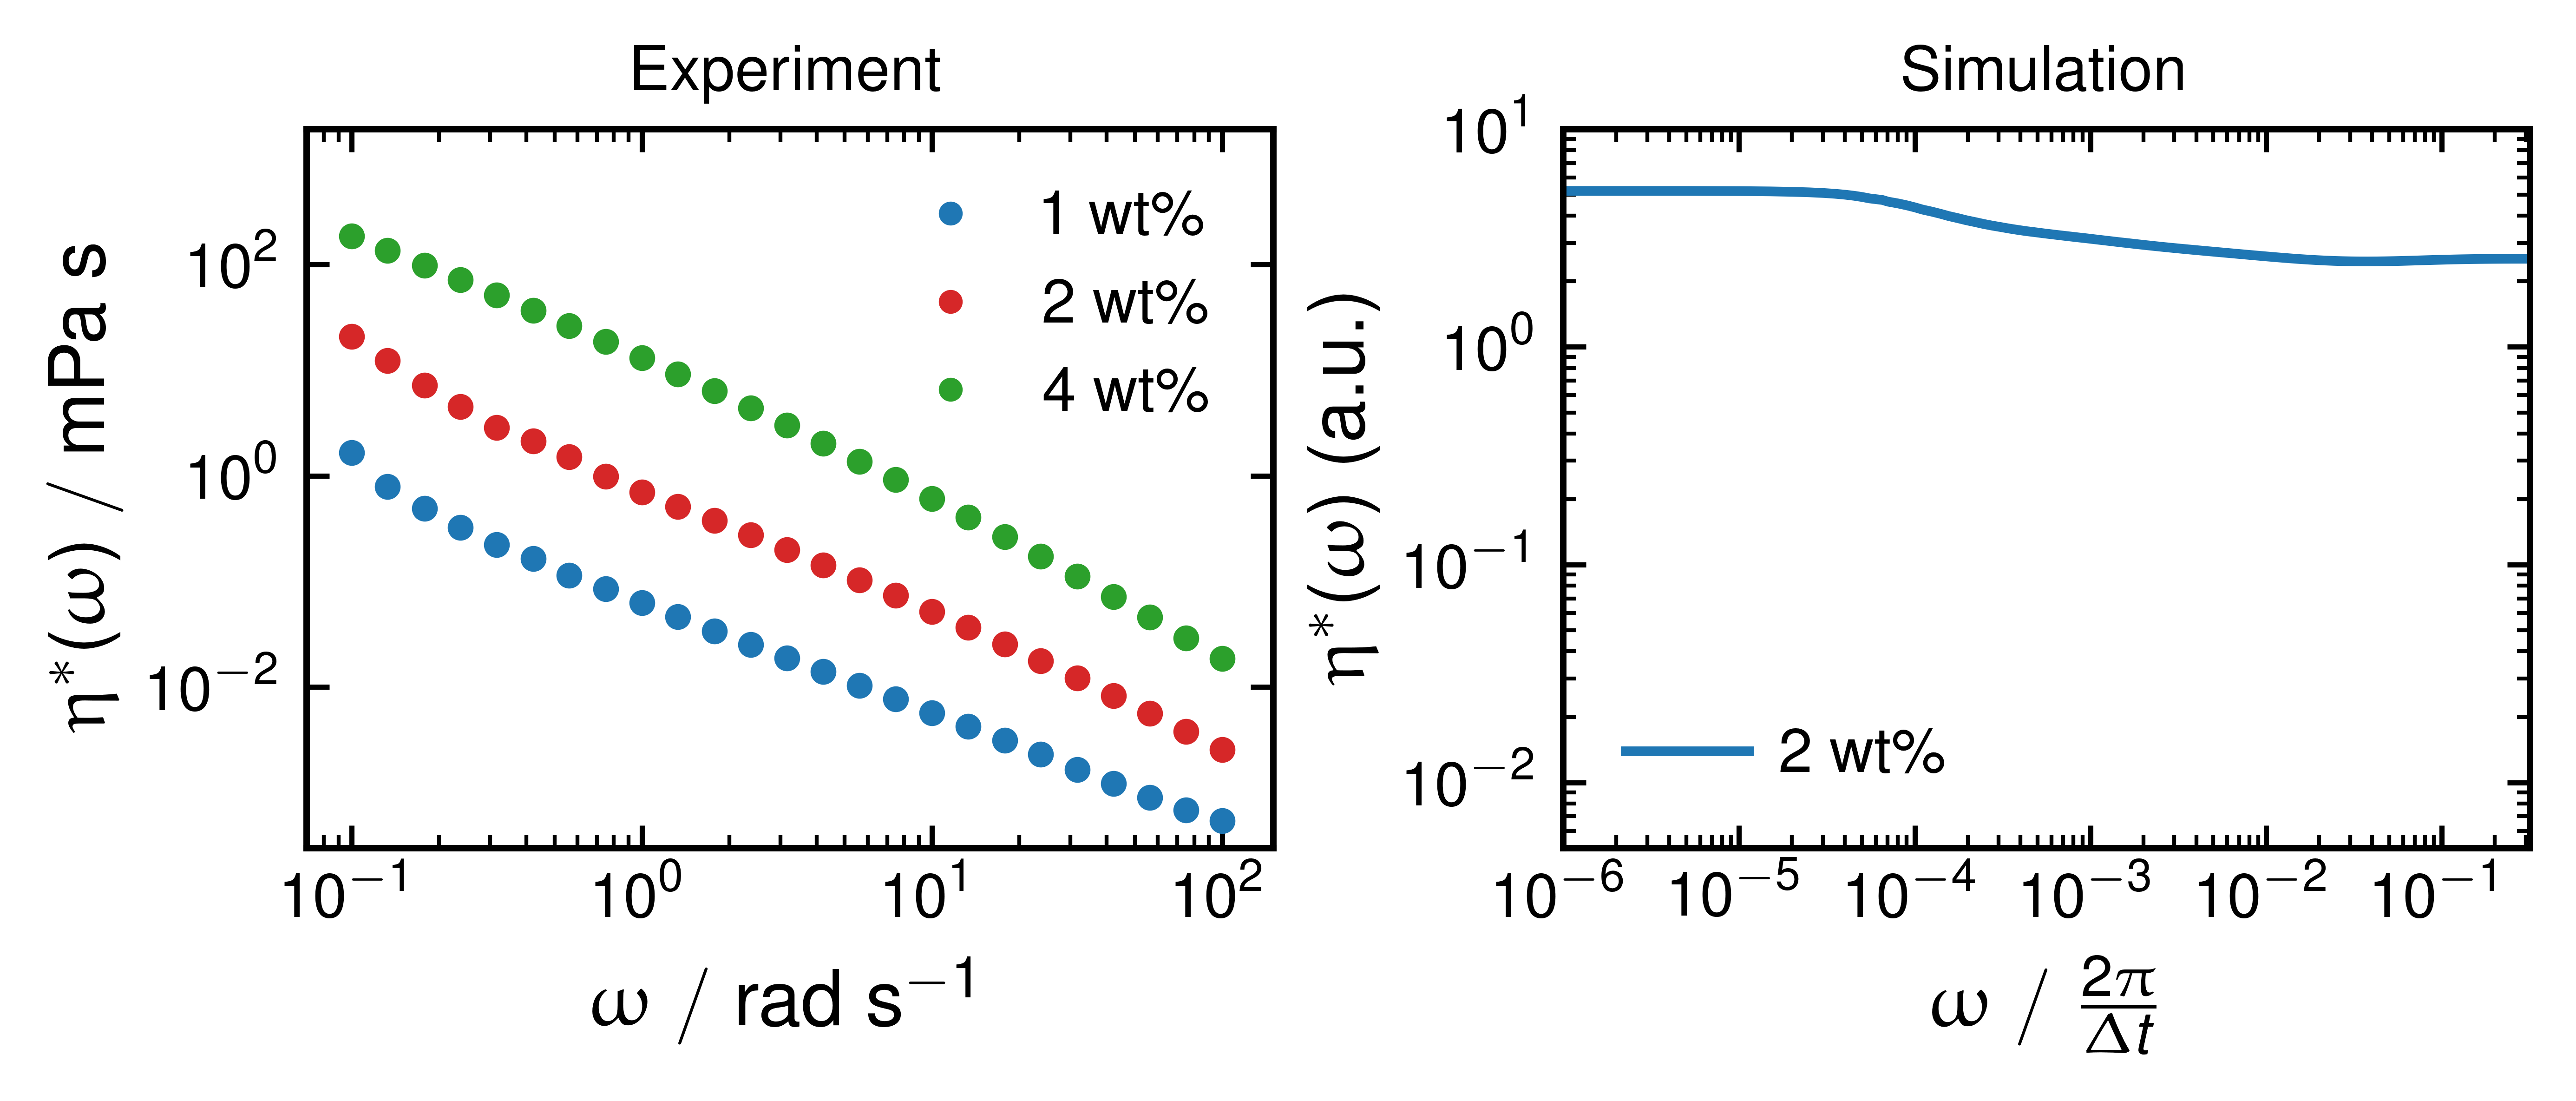

In [13]:
fontsize = 12

fig_width_pt = 347.5                    # dpi
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/(2.0)    # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inlw=2ches
fig_height = fig_width*golden_mean      # height in inches
fig_size = [fig_width,fig_height]

@mpltex.aps_decorator
def myplot():
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.dpi = 1000
    fig.set_size_inches(w=1.9*3.25, h=3.25/1.618)
    plt.subplots_adjust(wspace=0.30)
    #fig.set_size_inches(w=1.5*fig_width, h=fig_height)
    
    # The default line style is iterating over
    # color, line, and marker with hollow types.
    linestyles = mpltex.linestyles()

    ax1.set_xscale("log")
    ax1.set_yscale("log")
    
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    
    # for i in range(3):
    #     color = next(linestyles)["color"]
    #     ax.plot(complex_viscosity_single[i].real[:idx_plateau]*dt, label=f"real {single_label[i]}", color=color)
    #     ax.plot(complex_viscosity_single[i].imag[:idx_plateau]*dt, label=f"imag {single_label[i]}", color=color, linestyle="dashed")
    
    colors = []
    for _ in range(max(len(idx_selected), len(wtp_exp))):
        colors.append(next(linestyles)["color"])
        
        
    for idx_wtp, wtpi in enumerate(wtp_exp):
        ax1.plot(omega_exp_all[idx_wtp], abs_viscosity_exp_all[idx_wtp], "o", label=f"{wtpi} wt\%", color=colors[idx_wtp])
        
    for idx_label, idx in enumerate(idx_selected):
        
        ax2.plot(freq_steps_log_filtered_all[idx_label], abs_viscosity_log_all[idx_label], label=f"{label_selected[idx_label]}", linewidth=1.5, color=colors[idx_label])
    
    
    ylim = (1e-4, 5e2)
    
    ax1.set_xlabel(r"$\omega~/~\mathrm{rad}~\mathrm{s}^{-1}$")
    ax1.set_ylabel(r"$\eta^*(\omega)~/~\mathrm{mPa~s}$")
    
    ax1.set_xlim((7e-2, 1.5e2))
    ax1.set_ylim((3e-4, 1.9e3))

    #fig.tight_layout(pad=0.1)  # make layout as tight as possible
    #fig.savefig(figpath + "vspec_N51-L14-steps10M.png")
    ax1.tick_params(axis='both', which="both", labelsize=fontsize*0.8)
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
        item.set_fontsize(fontsize)
    for line in ax1.lines:
        line.set_linewidth(1.5)
        
    # ax.locator_params(nbins=5)  # limit the number of major ticks
    ax1.legend(fontsize=fontsize*0.8, loc='upper right')#, bbox_to_anchor=(1, 0.5))  # show legend in a best location
    
    #ax2.set_xlabel(r"$\omega~/~\mathrm{s}^{-1}$")
    ax2.set_xlabel(r"$\omega~/~\frac{2\pi}{\Delta t}$")
    ax2.set_ylabel(r"$\eta^*(\omega)~(\mathrm{a.u.})$")
    
    ax2.set_xlim((1e-6, freq_steps_log_filtered_all[0][-1]))
    #ax2.set_ylim((5e-2, 5e1))
    ax2.set_ylim((5e-3, 1e1))

    #fig.tight_layout(pad=0.1)  # make layout as tight as possible
    #fig.savefig(figpath + "vspec_N51-L14-steps10M.png")
    ax2.tick_params(axis='both', which="both", labelsize=fontsize*0.8)
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label]):
        item.set_fontsize(fontsize)
    for line in ax2.lines:
        line.set_linewidth(1.5)
        
    # ax.locator_params(nbins=5)  # limit the number of major ticks
    ax2.legend(fontsize=fontsize*0.8, loc='lower left')#, bbox_to_anchor=(1, 0.5))  # show legend in a best location
    
    ax1.set_title("Experiment")
    ax2.set_title("Simulation")
    #fig.savefig("/net/data04/janmak98/sfb_figures/viscosity_comparison_NEW.png", bbox_inches="tight")
    plt.show()
print(freq_steps_log_filtered_all[idx_label][-1])
myplot()


/tmp/ipykernel_70138/1005025548.py:33: RuntimeWarning: divide by zero encountered in divide
  ax.plot(freq[:idx_plateau-1000], 100*complex_viscosity.real[:idx_plateau-1000]*dt/freq[:idx_plateau-1000], label=f"{label_selected[idx_label]}", linewidth=1.5, color=color)
/tmp/ipykernel_70138/1005025548.py:34: RuntimeWarning: invalid value encountered in divide
  ax.plot(freq[:idx_plateau-1000], 100*complex_viscosity.imag[:idx_plateau-1000]*dt/freq[:idx_plateau-1000], linewidth=1.5, color=color, linestyle="dashed")


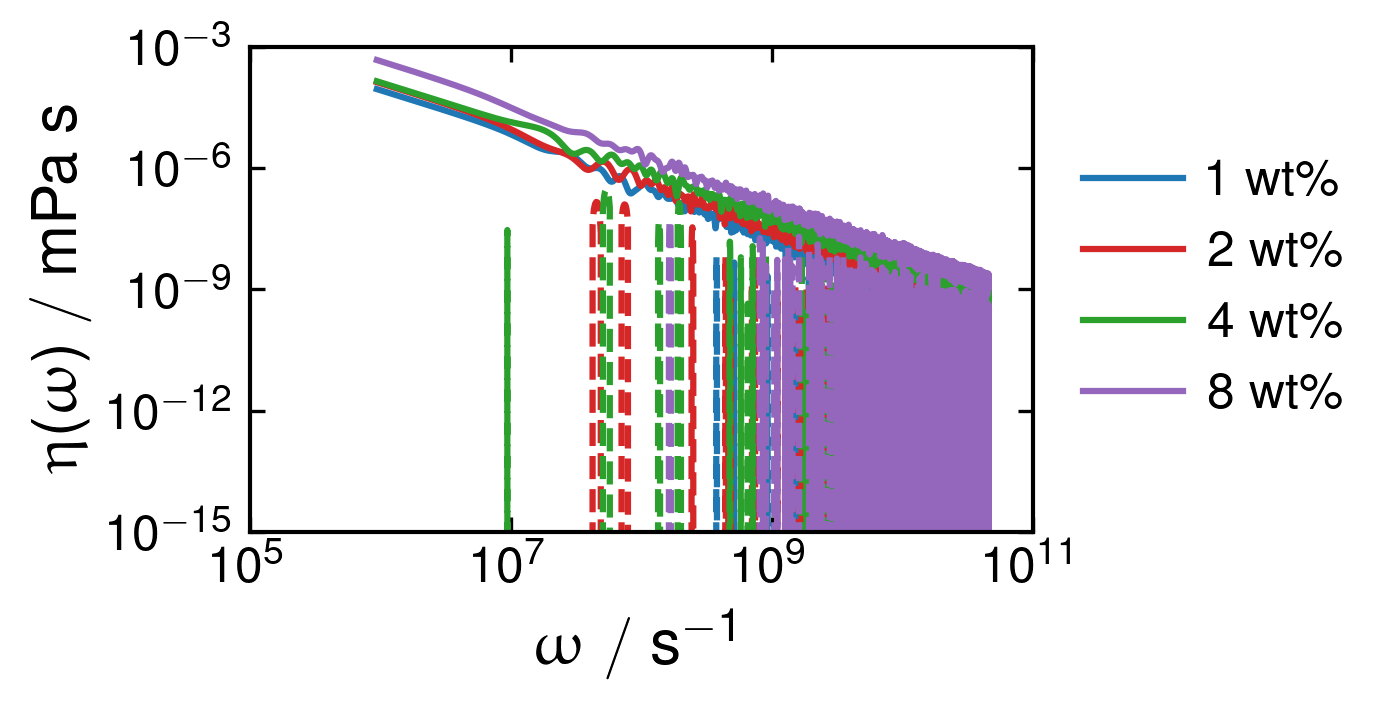

In [24]:
fontsize = 15

@mpltex.aps_decorator
def myplot():
    
    fig, ax = plt.subplots(1)
    fig.dpi = 300
    fig.set_size_inches(w=3.25, h=3.25/1.618)
    
    # The default line style is iterating over
    # color, line, and marker with hollow types.
    linestyles = mpltex.linestyles()

    ax.set_xscale("log")
    ax.set_yscale("log")
    # for i in range(3):
    #     color = next(linestyles)["color"]
    #     ax.plot(complex_viscosity_single[i].real[:idx_plateau]*dt, label=f"real {single_label[i]}", color=color)
    #     ax.plot(complex_viscosity_single[i].imag[:idx_plateau]*dt, label=f"imag {single_label[i]}", color=color, linestyle="dashed")
    
    for idx_label, idx in enumerate(idx_selected):
        
        freq = freq_all[idx_label]
        complex_viscosity = complex_viscosity_all[idx_label]
        idx_plateau = idx_max_all[idx_label]
        
        color = next(linestyles)["color"]
        # ax.plot(freq[:idx_plateau], complex_viscosity.real[:idx_plateau]*dt, label=f"real (all) {label_selected[idx_label]}", linewidth=1.5, color=color)
        # ax.plot(freq[:idx_plateau], 100*complex_viscosity.real[:idx_plateau]*dt, label=f"{label_selected[idx_label]}", linewidth=1.5, color=color)
        # ax.plot(freq[:idx_plateau], complex_viscosity.imag[:idx_plateau]*dt, label=f"imag (all) {label_selected[idx_label]}", linewidth=1.5, color=color, linestyle="dashed")
        # ax.plot(freq[:idx_plateau], 100*complex_viscosity.imag[:idx_plateau]*dt, linewidth=1.5, color=color, linestyle="dashed")
        
        ax.plot(freq[:idx_plateau-1000], 100*complex_viscosity.real[:idx_plateau-1000]*dt/freq[:idx_plateau-1000], label=f"{label_selected[idx_label]}", linewidth=1.5, color=color)
        ax.plot(freq[:idx_plateau-1000], 100*complex_viscosity.imag[:idx_plateau-1000]*dt/freq[:idx_plateau-1000], linewidth=1.5, color=color, linestyle="dashed")
    
    ax.set_xlabel(r"$\omega~/~\mathrm{s}^{-1}$")
    ax.set_ylabel(r"$\eta(\omega)~/~\mathrm{mPa~s}$")
    #ax.set_xlim((1e6, 1e10))
    #ax.set_ylim((1e-1, 5e-1))

    fig.tight_layout(pad=0.1)  # make layout as tight as possible
    #fig.savefig(figpath + "vspec_N51-L14-steps10M.png")
    ax.tick_params(axis='both', which="both", labelsize=fontsize*0.8)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(fontsize)
    for line in ax.lines:
        line.set_linewidth(1.5)
        
    # ax.locator_params(nbins=5)  # limit the number of major ticks
    ax.legend(fontsize=fontsize*0.8, loc='center left', bbox_to_anchor=(1, 0.5))  # show legend in a best location
    
    plt.show()

myplot()